# Train Convolutional Neural Network on Spectral Grid 

This notebook trains a Convolutional Neural Network (CNN) to predict atmospheric parameters of brown dwarfs from their spectra. The model uses dual inputs—1D spectral flux data and auxiliary metadata features—to predict four physical parameters: surface gravity (log g), carbon-to-oxygen ratio (C/O), metallicity ([M/H]), and effective temperature (log Teff). This serves as the foundation for subsequent explainability analysis comparing gradient-based (information content) and perturbation-based (SHAP) XAI methods.


This work builds on the TelescopeML CNN pipeline developed by Ehsan Gharib-Nezhad at NASA Ames Research Center. The dataset consists of synthetic brown dwarf spectra from the Sonora Bobcat model grid accessed through TelescopeML. My contributions include repliciating the pipeline and implementing explainability analyses using IC and SHAP.

### Setup

In [17]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model
import matplotlib.pyplot as plt
from bokeh.plotting import output_notebook
from bokeh.plotting import figure, show
import pickle

import sys
sys.path.append("../")
from src.TrainCNN import split_dataset, plot_ML_model_loss_bokeh

## **1. Data Preprocessing**

**Goal:** Load and prepare the brown dwarf spectral dataset for CNN training by performing train/val/test splitting, feature scaling, and feature engineering.

**Dataset:** Synthetic brown dwarf spectra at R=100 resolution from the Sonora Bobcat grid, containing ~100k spectra with varying atmospheric parameters.

Load the dataset into a DataFrame, with each row representing a spectrum and columns for both parameter values (output) and corresponding fluxes across wavelengths (input). Split the data into training, validation, and test sets, perform feature engineering, and standardize all features. The dataset should be structured as follows:

| Param 1     | Param 2     | Param 3     | ... | λ₁         | λ₂         | λ₃         | ... | λₙ         |
|-------------|-------------|-------------|-----|-------------|-------------|-------------|-----|-------------|
| value₁₁     | value₁₂     | value₁₃     | ... | flux₁₁      | flux₁₂      | flux₁₃      | ... | flux₁ₙ      |
| value₂₁     | value₂₂     | value₂₃     | ... | flux₂₁      | flux₂₂      | flux₂₃      | ... | flux₂ₙ      |
| ...         | ...         | ...         | ... | ...         | ...         | ...         | ... | ...         |



### **1.1 Load Dataset**

- Spectra: Flux measurements across ~100 wavelengths (0.9-2.5 μm) 
- Parameters: Four atmospheric properties—surface gravity (log g), carbon-to-oxygen ratio (C/O), metallicity ([M/H]), and effective temperature (log Teff)
- Dataset size: ~30,000 synthetic brown dwarf spectra from Sonora Bobcat model grid

In [18]:
# Load or create reference data path
__dataset_path__ = os.getenv("TelescopeML_reference_data")
__folder__ = "training_datasets"

# DataFrame with cols grid points then spectra
__dataset_file__ = "browndwarf_R100_v4_newWL_v3.csv.bz2"
dataset = pd.read_csv(os.path.join(__dataset_path__,__folder__,__dataset_file__), compression='bz2')

# Wavelength grid of model
__wavelength_file__ = "wl.csv"
wl_synthetic = pd.read_csv(os.path.join(__dataset_path__,__folder__,__wavelength_file__)).to_numpy().squeeze()

In [19]:
# Model parameters
parameters = np.array(['gravity',
             'temperature',
             'c_o_ratio',
             'metallicity'])

# Training variables
X = dataset.drop(
    columns=parameters)

# Target/Output feature variables
y = dataset[parameters]

# log transform temperature variable
y.loc[:, 'temperature'] = np.log10(y['temperature'])

### **1.2 Split Dataset into Train/Val/Test**

Standard 80/10/10 train/validation/test split ensures the model generalizes to unseen data and prevents overfitting.

In [20]:
X_train, X_test, X_val, y_train, y_test, y_val = split_dataset(flux_values=X.to_numpy(),
                                                               output_values=y.to_numpy())

### **1.3 Standardize X and Y**

Why standardize:
- Row-wise (spectra): Normalizes each spectrum's shape, removing absolute flux differences
- Column-wise (parameters): Puts all output variables on the same scale for balanced training
- Both approaches improve neural network convergence and training stability

In [21]:
__save__ = False

In [22]:
# Standardize X rowwise
scaler_X = StandardScaler()
X_train_standardized_rowwise = scaler_X.fit_transform(X_train.T).T
X_val_standardized_rowwise = scaler_X.fit_transform(X_val.T).T
X_test_standardized_rowwise = scaler_X.fit_transform(X_test.T).T

# Save X scaler 
if __save__:
    with open('scaler_X.pkl', 'wb') as f:
        pickle.dump(scaler_X, f)
    
# Standardize Y columnwise
scaler_y = StandardScaler()
y_train_standardized_columnwise = scaler_y.fit_transform(y_train)
y_val_standardized_columnwise = scaler_y.transform(y_val)
y_test_standardized_columnwise = scaler_y.transform(y_test)

# Save Y scaler
if __save__:
    with open('scaler_y.pkl', 'wb') as f:
        pickle.dump(scaler_y, f)

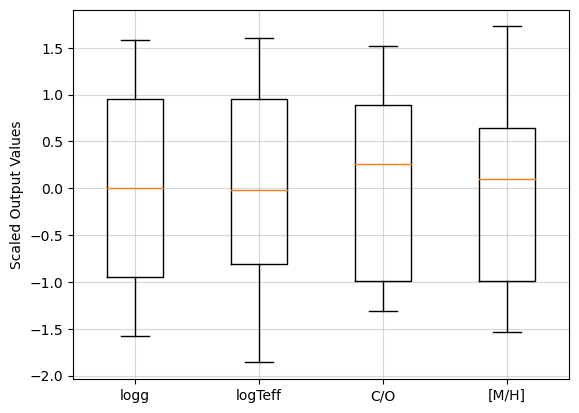

In [23]:
label_dict = {'gravity':'logg',
              'temperature':'logTeff',
              'c_o_ratio':'C/O',
              'metallicity':'[M/H]'}

# Check output standardization
plt.boxplot(y_train_standardized_columnwise)
plt.grid(alpha=0.5)
plt.xticks([1,2,3,4],labels=[label_dict[p] for p in parameters])
plt.ylabel("Scaled Output Values")
plt.show()

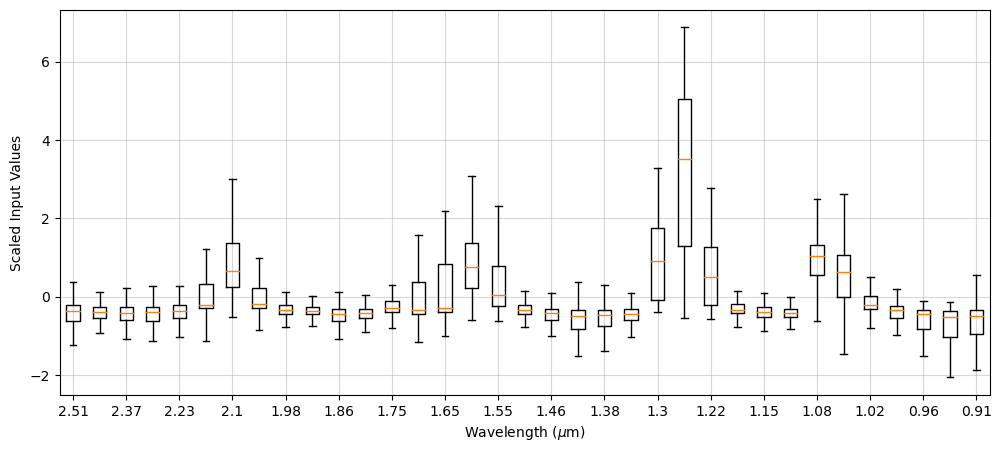

In [24]:
# Check input standardization
N = X_train_standardized_rowwise.shape[1]
n_boxes = 30
skip = max(1, N // n_boxes)
xticks = np.arange(1, X_train_standardized_rowwise[:, ::skip].shape[1] + 1)

plt.figure(figsize=(12, 5))
plt.boxplot(X_train_standardized_rowwise[:, ::skip], showfliers=False)
plt.xticks(xticks[::2], labels=np.round(wl_synthetic[::skip*2], 2))
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel("Scaled Input Values")
plt.grid(alpha=0.5)
plt.show()

### **1.4 Feature Engineering: Auxiliary Input**

Adding min/max flux metadata as auxiliary features helps the model learn spectral amplitude patterns alongside the detailed spectral shape, improving prediction accuracy.

In [25]:
# Create new feature for train, val, and test sets (metadata)
datasets = [X_train, X_val, X_test]
X_meta = [np.stack((X.min(axis=1), X.max(axis=1)), axis=1) for X in datasets]
X_train_meta, X_val_meta, X_test_meta = X_meta

In [26]:
# Standardize metadeta columnwise
scaler_X = StandardScaler()
X_train_standardized_columnwise = scaler_X.fit_transform(X_train_meta)
X_val_standardized_columnwise = scaler_X.transform(X_val_meta)
X_test_standardized_columnwise = scaler_X.transform(X_test_meta)

# Save meta scaler
if __save__:
    with open('scaler_X_meta.pkl', 'wb') as f:
        pickle.dump(scaler_X, f)

## **2. Build Model**

Prepare the input and output data for each target, hyperparameter tuning, build model architecture including convolutional layers, compile the model, and save. 

### **2.1 Prepare Input and Output for CNN**

We prepare the CNN training data as follows:
- **Inputs:**
  - `X1_*`: Row-standardized spectra for each instance (~100 wavelengths) → Conv layers extract local patterns
  - `X2_*`: Column-standardized min/max flux values per instance (2 values) → Dense layers process global information
- **Targets:**
  - `y1_*`: log(g)
  - `y2_*`: C/O ratio
  - `y3_*`: [M/H]
  - `y4_*`: log(Teff)

All inputs/outputs have been split into train, validation, and test sets.

In [27]:
# input dataset: StandardScaled instances
X1_train = X_train_standardized_rowwise
X1_val   = X_val_standardized_rowwise
X1_test  = X_test_standardized_rowwise

# input dataset: Min Max of each instance
X2_train = X_train_standardized_columnwise
X2_val   = X_val_standardized_columnwise
X2_test  = X_test_standardized_columnwise

# 1st target
y1_train = y_train_standardized_columnwise[:,0] # logg
y1_val   = y_val_standardized_columnwise[:,0]
y1_test  = y_test_standardized_columnwise[:,0]

# 2nd target
y2_train = y_train_standardized_columnwise[:,1] # C/O
y2_val   = y_val_standardized_columnwise[:,1]
y2_test  = y_test_standardized_columnwise[:,1]

# 3rd target
y3_train = y_train_standardized_columnwise[:,2] # [M/H]
y3_val   = y_val_standardized_columnwise[:,2]
y3_test  = y_test_standardized_columnwise[:,2]

# 4th target
y4_train = y_train_standardized_columnwise[:,3] # logTeff
y4_val   = y_val_standardized_columnwise[:,3]
y4_test  = y_test_standardized_columnwise[:,3]

In [28]:
train_outputs = [y1_train, y2_train, y3_train, y4_train]
val_outputs = [y1_val, y2_val, y3_val, y4_val]

### **2.2 BOHB Tuning**

Used Bayesian Optimization with HyperBand (BOHB) to efficiently search hyperparameter space. This advanced technique significantly reducing computational cost compared to grid search. Tuned parameters include:
- Convolutional architecture (filters, kernel sizes, pooling)
- Dense layer dimensions and dropout rates  
- Learning rate for optimizer

In [29]:
# Assign model hyperparameters
Conv__filters = 32
Conv__kernel_size = 4
Conv__MaxPooling1D = 3
Conv__NumberLayers = 3
Conv__NumberBlocks = 2

FC1__units = 256
FC1__dropout = 0.0013358917126831819
FC1__NumberLayers = 3

FC2__units = 128
FC2__NumberLayers = 4
FC2__dropout = 0.0018989744374361271
FC2__NumberBlocks = 1

lr = 0.00018890368162236508

### **2.3 Build Model**

#### Architecture Overview:
1. Feature Extraction: Multiple convolutional blocks progressively capture hierarchical spectral features (local patterns → broader structures)
2. Dimensionality Reduction: MaxPooling layers downsample between blocks while preserving key information
3. Feature Fusion: Concatenate extracted spectral features with metadata
4. Regression Heads: Four separate output layers predict each atmospheric parameter independently

First define the inputs:
- input_1: the 1D spectral data with shape (N wavelengths, 1 channel).
- input_2: auxiliary features (min/max flux) with shape (2,).

In [30]:
# Shape of the inputs
input_1 = tf.keras.layers.Input(shape=(N, 1)) # Add dimension
input_2 = tf.keras.layers.Input(shape=(2,))

Build convolutional blocks on input_1 to extract hierarchical spectral features:
- Each block has multiple Conv1D layers with increasing filters.
- Each block ends with MaxPooling1D to downsample: highlight key features.

In [31]:
# Create Conv Blocks
model = input_1
for b in range(0, Conv__NumberBlocks):
    for l in range(0, Conv__NumberLayers):
        model = Conv1D(filters=Conv__filters * (b + l + 1) ** 2,
                       kernel_size=Conv__kernel_size,
                       strides = 1,
                       padding ='same',
                       activation='relu',
                       kernel_initializer='he_normal',
                       name='Conv__B' + str(b + 1) + '_L' + str(l + 1))(model)  # (model if l!= 0 and b!= 0 else input_1)

    model = MaxPooling1D(pool_size=(Conv__MaxPooling1D),
                         name='Conv__B' + str(b + 1) + '__MaxPooling1D')(model)

Flatten the output of the convolutional layers to prepare for dense layers.

In [32]:
# Flatten Layer
model = Flatten()(model)

Pass through fully connected (FC) layers before concatenation:
- Number of units increases quadratically per layer.
- Dropout is applied for regularization (prevent overfitting).

In [33]:
# FC Layer before the Concatenation
for l in range(FC1__NumberLayers):
    model = Dense(FC1__units * (l + 1) ** 2,
                  activation='relu',
                  kernel_initializer='he_normal',
                  name='FC1__B1_L' + str(l + 1))(model)

model = Dropout(FC2__dropout,
                name='FC1__B1_L' + str(l + 1) + '__Dropout')(model)

Concatenate the FC output with the auxiliary input_2 to combine spectral and meta features.

In [34]:
# Concatenation Layer: Concatenate the outputs from the convolutional layers and dense layer
model = tf.keras.layers.concatenate([model, input_2],
                                    name='Concatenated_Layer')

Process the concatenated features through additional FC blocks:
- Each block has multiple dense layers with increasing units.
- Dropout is applied for regularization (prevent overfitting).

In [35]:
# FC Block
for b in range(0, FC2__NumberBlocks):
    for l in range(0, FC2__NumberLayers):
        model = Dense(FC2__units * (b + l + 1) ** 2,
                      activation='relu',
                      kernel_initializer='he_normal',
                      name='FC2__B' + str(b + 1) + '_L' + str(l + 1))(model)  # (model if l!= 0 and b!= 0 else input_1)
    model = Dropout(FC2__dropout,
                    name='FC2__B'+ str(b + 1) + '_L' + str(l + 1) + '__Dropout')(model)
    

In [36]:
# 3rd FC Block: gravity
out__gravity = Dense(1,
                     activation='linear',
                     name='output__gravity')(model)

# 3rd FC Block: c_o_ratio
out__c_o_ratio = Dense(1,
                       activation='linear',
                       name='output__c_o_ratio')(model)

# 3rd FC Block: metallicity
out__metallicity = Dense(1,
                         activation='linear',
                         name='output__metallicity')(model)

# 3rd FC Block: temperature
out__temperature = Dense(1,
                         activation='linear',
                         name='output__temperature')(model)

In [37]:
model_outputs = [out__gravity, out__c_o_ratio, out__metallicity, out__temperature]

In [38]:
# Create the model with two inputs and four outputs
model = tf.keras.Model(inputs=[input_1, input_2],
                       outputs=model_outputs)

### **2.4 Run the CNN Training**

Select number of epochs (budget) and batch size.

In [ ]:
# Test values for demonstration
batch_size = 100 #32
budget = 20 #70

In [40]:
# Compile the model with an optimizer, loss function, and metrics
model.compile(loss='huber_loss',
                   optimizer=keras.optimizers.Adam(learning_rate=lr),
                   metrics=['mae'])

In [41]:
# Instantiate early stopping
early_stop = EarlyStopping(monitor='loss', min_delta=4e-4, patience=50, mode='auto', \
                           restore_best_weights=True)

Here we initialize the model training. 

In [ ]:
# Fit the model
history = model.fit(x=[X1_train, X2_train],
                         y=train_outputs,
                         batch_size = batch_size,  
                         validation_data=(
                         [X1_val, X2_val], val_outputs),
                         epochs=int(budget),
                         verbose=1,
                         callbacks=[early_stop]
                        )

Epoch 1/20
251/251 [==============================] - 60s 227ms/step - loss: 0.5321 - output__gravity_loss: 0.1655 - output__c_o_ratio_loss: 0.0879 - output__metallicity_loss: 0.1118 - output__temperature_loss: 0.1669 - output__gravity_mae: 0.4420 - output__c_o_ratio_mae: 0.2207 - output__metallicity_mae: 0.3430 - output__temperature_mae: 0.4378 - val_loss: 0.1541 - val_output__gravity_loss: 0.0479 - val_output__c_o_ratio_loss: 0.0051 - val_output__metallicity_loss: 0.0314 - val_output__temperature_loss: 0.0697 - val_output__gravity_mae: 0.2352 - val_output__c_o_ratio_mae: 0.0776 - val_output__metallicity_mae: 0.2009 - val_output__temperature_mae: 0.2958
Epoch 2/20
251/251 [==============================] - 66s 261ms/step - loss: 0.1346 - output__gravity_loss: 0.0408 - output__c_o_ratio_loss: 0.0053 - output__metallicity_loss: 0.0269 - output__temperature_loss: 0.0616 - output__gravity_mae: 0.2174 - output__c_o_ratio_mae: 0.0794 - output__metallicity_mae: 0.1811 - output__temperature_m

### **2.5 Save model**

In [ ]:
__model_file__ = "sonora_bobcat_CNN.keras"

if __save__:
    model.save(__model_file__)

## **3. Inspect Output**

Using Bokeh, plot the model loss.

In [ ]:
output_notebook()

Loading BokehJS ...

In [67]:
plot_ML_model_loss_bokeh(trained_ML_model_history=history)